# TGNNs for traffic forecasting:

## 1- Instalations:


In [ ]:
import torch
from IPython.display import Image
print('Setup complete. Using torch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))
pt_version = torch.__version__
print(pt_version)

In [ ]:
print(torch.__version__)
print(torch.version.cuda)

2.4.0
12.3


This cell installs all the necessary libraries for the project, including:



*   torch-scatter, torch-sparse, torch-cluster, torch-spline-conv: Required PyTorch extensions for efficient operations on sparse data structures, essential for graph neural networks.
*   torch-geometric: A library for deep learning on irregularly structured data like graphs.
*   torch-geometric-temporal: An extension of torch-geometric specifically designed for spatiotemporal data and temporal graph neural networks (TGNNs).

(these took a long time to install)



In [ ]:
!pip install torch-scatter -f https://pytorch-geometric.com/whl/torch-${pt_version}.html
!pip install torch-sparse -f https://pytorch-geometric.com/whl/torch-${pt_version}.html
!pip install torch-cluster -f https://pytorch-geometric.com/whl/torch-${pt_version}.html
!pip install torch-spline-conv -f https://pytorch-geometric.com/whl/torch-${pt_version}.html
!pip install torch-geometric
!pip install torch-geometric-temporal

## 2- Dataset importation

this is used to fix an error, it replaces occurrences of the import statement from torch_geometric.utils.to_dense_adj import to_dense_adj with from torch_geometric.utils import to_dense_adj in the specified Python file. This is done to update or correct import statements due to changes in the library's module structure.

In [ ]:
!sed -i 's/from torch_geometric.utils.to_dense_adj import to_dense_adj/from torch_geometric.utils import to_dense_adj/g' /opt/conda/lib/python3.10/site-packages/torch_geometric_temporal/nn/attention/tsagcn.py


- Traffic forecasting dataset based on Los Angeles Metropolitan traffic
- 207 loop detectors on highways
- March 2012 - June 2012
- From the paper: Diffusion Convolutional Recurrent Neural Network

loading and preparing the METR-LA dataset for the model:

- SSL Certificate Verification Disabled: The first few lines disable SSL certificate verification to handle any SSL errors that might occur during dataset downloading.

- Load Dataset: Utilizes the METRLADatasetLoader from torch_geometric_temporal to load the METR-LA dataset, specifying a window of 12 timesteps for both inputs and outputs.

In [ ]:
import ssl
import urllib

# Disable SSL certificate verification
ssl._create_default_https_context = ssl._create_unverified_context

import numpy as np
from torch_geometric_temporal.dataset import METRLADatasetLoader
from torch_geometric_temporal.signal import StaticGraphTemporalSignal

loader = METRLADatasetLoader()
dataset = loader.get_dataset(num_timesteps_in=12, num_timesteps_out=12)

print("Dataset type:  ", dataset)
print("Number of samples / sequences (time steps): ", len(dataset.features))
print("Shape of each sample (node features): ", dataset.features[0].shape)

Dataset type:   <torch_geometric_temporal.signal.static_graph_temporal_signal.StaticGraphTemporalSignal object at 0x79bc3cb42b00>
Number of samples / sequences (time steps):  34249
Shape of each sample (node features):  (207, 2, 12)


Data Sample
- 207 nodes
- 2 features per node (speed, time)
- 12 timesteps per bucket (12 x 5 min = 60 min)
- Labels for 12 future timesteps (normalized speed) --> node regression
- Edge_attr is build based on the distances between sensors + threshold

In [ ]:
# Show first sample
next(iter(dataset))

Data(x=[207, 2, 12], edge_index=[2, 1722], edge_attr=[1722], y=[207, 12])

The plot represents the normalized speed of traffic over a 24-hour period for Sensor 1. The x-axis indicates time in hours, while the y-axis shows the normalized speed values.

- **Fluctuation**: The traffic speed varies considerably throughout the day, with multiple peaks and troughs.
- **Range**: The normalized speed ranges approximately from 0.38 to 0.70, indicating significant changes in traffic conditions.
- **Peak speeds**: The highest speeds occur around hours 13-14, with another notable peak near hour 22.
- **Low points**: The lowest speeds are observed around hours 7-10, possibly corresponding to morning rush hour.
- **Patterns**: There seem to be cyclical patterns, potentially reflecting daily traffic rhythms (e.g., rush hours, off-peak times).
- **Variability**: The speed changes are quite abrupt in some cases, suggesting rapid shifts in traffic conditions.

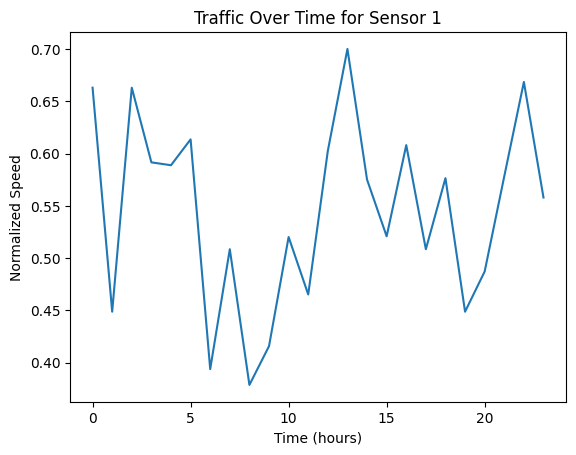

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Visualize traffic over time for a specific sensor
sensor_number = 1
hours = 24

sensor_labels = [bucket.y[sensor_number][0].item() for bucket in list(dataset)[:hours]]
sns.lineplot(data=sensor_labels)

plt.xlabel('Time (hours)')
plt.ylabel('Normalized Speed')
plt.title(f'Traffic Over Time for Sensor {sensor_number}')
plt.show()

This heatmap provides a comprehensive view of normalized speeds across multiple sensors over a 24-hour period. Here's an analysis of the key observations:

- Temporal Patterns:

Most sensors show clear daily patterns with varying speeds throughout the day.
There seems to be a general trend of higher speeds (yellower areas) during early morning hours (around 0-5) and late evening (around 20-23).
Lower speeds (greener and bluer areas) are more common during midday and afternoon hours.


- Sensor Variability:

Different sensors exhibit distinct patterns, indicating varied traffic conditions across locations.
Some sensors (e.g., 8, 16, 18, 19) show consistently lower speeds compared to others.
Sensors 0-7 and 12-15 appear to have more dynamic speed changes throughout the day.


- Anomalies:

Sensor 11 shows an unusual pattern with extremely low speeds (dark purple) for several consecutive hours, which could indicate a traffic incident or data anomaly.
Sensor 16 consistently shows very low speeds, which might suggest a persistently congested area or a sensor placed in a slow-traffic zone.


- Rush Hour Indications:

Many sensors show lower speeds (greener colors) around hours 7-9 and 16-18, potentially corresponding to morning and evening rush hours.


- Night-time Patterns:

Generally higher speeds (more yellow) are observed during night hours, likely due to lower traffic volumes.

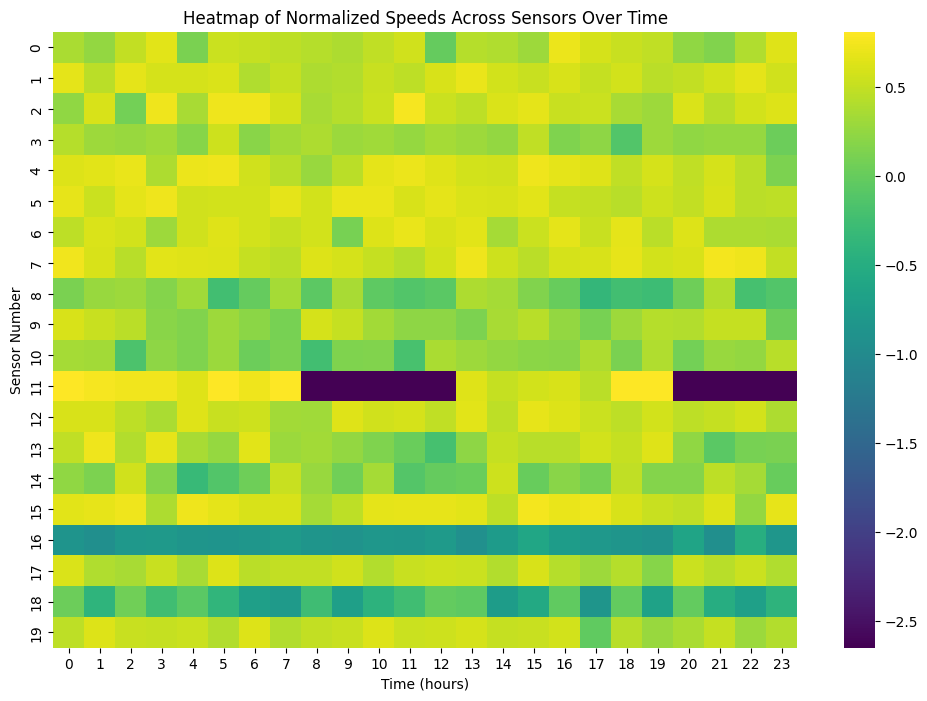

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Choose a time range for visualization (e.g., first 24 hours)
time_range = 24
sensor_speeds = []

# Extract speed data for each sensor over the specified time range
for sensor_number in range(20):
    speeds = [bucket.y[sensor_number][0].item() for bucket in list(dataset)[:time_range]]
    sensor_speeds.append(speeds)

# Convert to a NumPy array for easier plotting
sensor_speeds = np.array(sensor_speeds)

# Create a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(sensor_speeds, cmap='viridis', xticklabels=range(time_range), yticklabels=range(20))
plt.xlabel('Time (hours)')
plt.ylabel('Sensor Number')
plt.title('Heatmap of Normalized Speeds Across Sensors Over Time')
plt.show()

## 3- Implementation:

Using GPU if available.  
Unfortunately, google colab GPU have a limited time usage soo it kept disconnecting before even reaching the training stage so i just stick with CPU even though it will make the training take way longer time.  
I also tried using my local machine with jupyter but since my pc doesn't have a strong GPU, once I started the training my pc crunched, fortunately it just auto restarted and nothing big happened.  

for this model I used kaggle since it offers powerful GPU and lots of RAM, thats why some output results may seems off.

In [ ]:
# Check for GPU availability
if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
    print("GPU is enabled and available.")
else:
    DEVICE = torch.device('cpu')
    print("GPU is not available. Using CPU instead.")


GPU is enabled and available.


Splitting data into test data and train data

In [ ]:
from torch_geometric_temporal.signal import temporal_signal_split
train_dataset, test_dataset = temporal_signal_split(dataset, train_ratio=0.8)

print("Number of train buckets: ", len(train_dataset.features))
print("Number of test buckets: ", len(test_dataset.features))

Number of train buckets:  27399
Number of test buckets:  6850


In [ ]:
shuffle=True
batch_size = 32

This code sets up data pipelines for training, validation, and testing a machine learning model using PyTorch. It converts training and test datasets into PyTorch tensors and splits the training data into training and validation sets based on a specified ratio. The code then creates `DataLoader` objects for each dataset, allowing for efficient batch processing and optional shuffling of training data. This setup ensures that the model is trained on a portion of the data, validated on another portion to tune hyperparameters, and tested on a separate dataset to evaluate its performance.

In [ ]:
import numpy as np
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric_temporal.nn.recurrent import A3TGCN2
import pytorch_lightning as L
from pytorch_lightning.callbacks import EarlyStopping, Timer
from torch.utils.data import DataLoader, TensorDataset, random_split

# Data Preparation
def prepare_data(train_dataset, test_dataset, batch_size, val_split=0.1, shuffle=True):
    # Prepare train data
    train_input = np.array(train_dataset.features)
    train_target = np.array(train_dataset.targets)
    train_x_tensor = torch.from_numpy(train_input).type(torch.FloatTensor)
    train_target_tensor = torch.from_numpy(train_target).type(torch.FloatTensor)

    # Create validation split
    dataset_size = len(train_x_tensor)
    val_size = int(val_split * dataset_size)
    train_size = dataset_size - val_size
    train_dataset, val_dataset = random_split(TensorDataset(train_x_tensor, train_target_tensor),
                                              [train_size, val_size])

    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle, drop_last=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, drop_last=True)

    # Prepare test data
    test_input = np.array(test_dataset.features)
    test_target = np.array(test_dataset.targets)
    test_x_tensor = torch.from_numpy(test_input).type(torch.FloatTensor)
    test_target_tensor = torch.from_numpy(test_target).type(torch.FloatTensor)
    test_dataset = TensorDataset(test_x_tensor, test_target_tensor)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=True)

    return train_loader, val_loader, test_loader

sets a random seed to ensure reproducibility in our project and to  helps in debugging.

In [ ]:
# Set random seed for reproducibility
import numpy as np
import random

seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

## 4- Creating the A3TGCN model

The code below defines a PyTorch Lightning module for a temporal graph neural network (GNN). The `TemporalGNN` class initializes with a model architecture consisting of an `A3TGCN2` layer, followed by fully connected layers, dropout, and batch normalization. It includes methods for forward propagation (`forward`), training (`training_step`), validation (`validation_step`), and testing (`test_step`), each calculating and logging mean squared error (MSE) loss. The `configure_optimizers` method sets up an Adam optimizer with a learning rate scheduler that adjusts the learning rate based on validation loss. The `set_static_edge_index` method allows setting the static edge index for the GNN. This setup facilitates efficient training, validation, and testing of the temporal GNN model using PyTorch Lightning's features.

In [ ]:
from pytorch_lightning.callbacks import EarlyStopping, Timer, LearningRateMonitor
from torch.utils.data import DataLoader, TensorDataset, random_split
from pytorch_lightning.loggers import TensorBoardLogger

class TemporalGNN(L.LightningModule):
    def __init__(self, node_features, periods, batch_size, lr=0.001, weight_decay=1e-5):
        super(TemporalGNN, self).__init__()
        self.save_hyperparameters()
        self.tgnn = A3TGCN2(in_channels=node_features, out_channels=64, periods=periods, batch_size=batch_size)
        self.linear1 = torch.nn.Linear(64, 32)
        self.linear2 = torch.nn.Linear(32, periods)
        self.dropout = torch.nn.Dropout(p=0.2)
        self.batch_norm = torch.nn.BatchNorm1d(64)

    def forward(self, x, edge_index):
        h = self.tgnn(x, edge_index)
        h = self.batch_norm(h.transpose(1, 2)).transpose(1, 2)
        h = F.relu(h)
        h = self.dropout(h)
        h = F.relu(self.linear1(h))
        h = self.dropout(h)
        h = self.linear2(h)
        return h

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x, self.static_edge_index)
        loss = F.mse_loss(y_hat, y)
        self.log('train_loss', loss, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x, self.static_edge_index)
        loss = F.mse_loss(y_hat, y)
        self.log('val_loss', loss, prog_bar=True)
        return loss

    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x, self.static_edge_index)
        loss = F.mse_loss(y_hat, y)
        self.log('test_loss', loss)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.hparams.lr, weight_decay=self.hparams.weight_decay)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.5)
        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": scheduler,
                "monitor": "val_loss",
            },
        }

    def set_static_edge_index(self, static_edge_index):
        self.static_edge_index = static_edge_index

The code below helps in understanding the model architecture by displaying the sizes of its parameters and verifies the optimizer's configuration.  
1.  Model and Optimizer Creation:

- It initializes an instance of the TemporalGNN model with specific parameters
(node_features=2, periods=12, batch_size=batch_size) and moves it to the specified device (DEVICE).
- It also creates an Adam optimizer for the model's parameters with a learning rate of 0.001 and a mean squared error (MSE) loss function.
2.  Printing Model State Dictionary:

- It prints the state dictionary of the model, which includes the names and sizes of all parameters (weights and biases) in the model.
- It calculates and prints the total number of parameters in the model.
3.  Printing Optimizer State Dictionary:

- It prints the state dictionary of the optimizer, which contains information about the optimizer's internal state and parameter groups.
- In this case, the optimizer's state is empty (indicating no accumulated state yet), and the param_groups shows the configuration of the optimizer, including the learning rate, betas, weight decay, and the list of parameter indices being optimized.

In [ ]:
# Create model and optimizers
model = TemporalGNN(node_features=2, periods=12, batch_size=batch_size).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = torch.nn.MSELoss()


print('Net\'s state_dict:')
total_param = 0
for param_tensor in model.state_dict():
    print(param_tensor, '\t', model.state_dict()[param_tensor].size())
    total_param += np.prod(model.state_dict()[param_tensor].size())
print('Net\'s total params:', total_param)
#--------------------------------------------------
print('Optimizer\'s state_dict:')
for var_name in optimizer.state_dict():
    print(var_name, '\t', optimizer.state_dict()[var_name])

Net's state_dict:
tgnn._attention 	 torch.Size([12])
tgnn._base_tgcn.conv_z.bias 	 torch.Size([64])
tgnn._base_tgcn.conv_z.lin.weight 	 torch.Size([64, 2])
tgnn._base_tgcn.linear_z.weight 	 torch.Size([64, 128])
tgnn._base_tgcn.linear_z.bias 	 torch.Size([64])
tgnn._base_tgcn.conv_r.bias 	 torch.Size([64])
tgnn._base_tgcn.conv_r.lin.weight 	 torch.Size([64, 2])
tgnn._base_tgcn.linear_r.weight 	 torch.Size([64, 128])
tgnn._base_tgcn.linear_r.bias 	 torch.Size([64])
tgnn._base_tgcn.conv_h.bias 	 torch.Size([64])
tgnn._base_tgcn.conv_h.lin.weight 	 torch.Size([64, 2])
tgnn._base_tgcn.linear_h.weight 	 torch.Size([64, 128])
tgnn._base_tgcn.linear_h.bias 	 torch.Size([64])
linear1.weight 	 torch.Size([32, 64])
linear1.bias 	 torch.Size([32])
linear2.weight 	 torch.Size([12, 32])
linear2.bias 	 torch.Size([12])
batch_norm.weight 	 torch.Size([64])
batch_norm.bias 	 torch.Size([64])
batch_norm.running_mean 	 torch.Size([64])
batch_norm.running_var 	 torch.Size([64])
batch_norm.num_batches_tra

since we have a static graph data (the chape of the data edges dont change over time) we can extracts the edge index of the first snapshot from the train_dataset and moves it to the specified device (DEVICE) to get a sample edge index for further use, such as initializing or inspecting graph data.

In [ ]:
for snapshot in train_dataset:
    static_edge_index = snapshot.edge_index.to(DEVICE)
    break;

This code snippet sets up the environment for training a temporal graph neural network (GNN) model using PyTorch and PyTorch Lightning. It first checks if a GPU is available and sets the device accordingly. The data is prepared by creating data loaders for training, validation, and testing using the `prepare_data` function. The `TemporalGNN` model is then instantiated with specific parameters, such as the number of node features, periods, batch size, learning rate, and weight decay. The model's static edge index, which represents the graph structure, is set on the chosen device (GPU or CPU).

To manage the training process, two callbacks are set up: a `Timer` to monitor the training duration and `EarlyStopping` to halt training if the validation loss does not improve for 10 consecutive epochs. These callbacks are stored in a list and can be passed to the PyTorch Lightning trainer to enhance the training process with time tracking and early stopping mechanisms.

In [ ]:
# Usage example
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
batch_size = 32

# Prepare data
train_loader, val_loader, test_loader = prepare_data(train_dataset, test_dataset, batch_size)

# Create model
model = TemporalGNN(node_features=2, periods=12, batch_size=batch_size, lr=0.001, weight_decay=1e-5)
model.set_static_edge_index(static_edge_index.to(DEVICE))

# Setup callbacks
timer = Timer()
early_stopping = EarlyStopping(patience=10, monitor="val_loss", mode="min")
callbacks = [timer, early_stopping]

This code snippet initializes a PyTorch Lightning `Trainer` to manage the training process for the temporal GNN model. The `Trainer` is configured to use a GPU if available; otherwise, it defaults to the CPU. It sets the number of devices to 1, meaning the model will be trained on a single device (GPU or CPU). The `num_sanity_val_steps` parameter is set to 0, which skips any initial validation sanity checks, allowing for a quicker start. The previously defined `callbacks` list (which includes the `Timer` and `EarlyStopping`) is passed to manage the training duration and implement early stopping. The training is set to run for a maximum of 200 epochs, and the logs will be saved to the default directory `"./lightning_logs"`.

The `trainer.fit()` method is then called to start the training process, using the specified model, training data loader (`train_loader`), and validation data loader (`val_loader`). During the training, the model's performance is evaluated at each epoch, here the training stops after 47 epochs with a final training loss of 0.538 and a validation loss of 0.440. These results suggest that the model is learning to generalize well to unseen data, as indicated by the decreasing loss values over the epochs.

(since the model was trained in kaggle if you are opening the code file in jupyter or google colab the output might seem off)

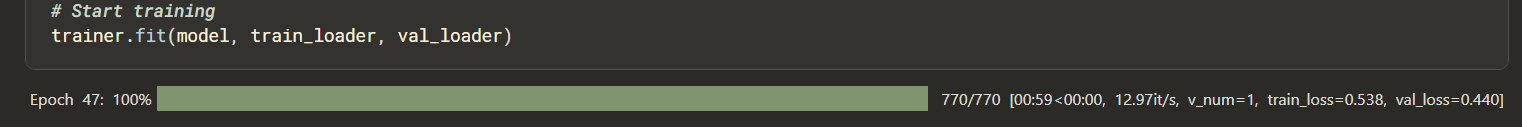

In [ ]:
# Create trainer
trainer = L.Trainer(
    accelerator="gpu" if torch.cuda.is_available() else "cpu",
    devices=1,
    num_sanity_val_steps=0,
    callbacks=callbacks,
    max_epochs=200,
    default_root_dir="./lightning_logs"
)

# Start training
trainer.fit(model, train_loader, val_loader)

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [ ]:
# Load the best model checkpoint after training
best_model = TemporalGNN.load_from_checkpoint(trainer.checkpoint_callback.best_model_path)

# Ensure the model is on the correct device
best_model.to(DEVICE)


TemporalGNN(
  (tgnn): A3TGCN2(
    (_base_tgcn): TGCN2(
      (conv_z): GCNConv(2, 64)
      (linear_z): Linear(in_features=128, out_features=64, bias=True)
      (conv_r): GCNConv(2, 64)
      (linear_r): Linear(in_features=128, out_features=64, bias=True)
      (conv_h): GCNConv(2, 64)
      (linear_h): Linear(in_features=128, out_features=64, bias=True)
    )
  )
  (linear1): Linear(in_features=64, out_features=32, bias=True)
  (linear2): Linear(in_features=32, out_features=12, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (batch_norm): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

## 5-Evaluation

code snippet ensures that the model and its associated data are transferred to the appropriate device (GPU or CPU) for computation.

In [ ]:
model = model.to(DEVICE)
model.static_edge_index = model.static_edge_index.to(DEVICE)
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

the code below defines a function, `evaluate_model`, that evaluates a trained model's performance on a given dataset using a DataLoader in PyTorch. The function sets the model to evaluation mode with `model.eval()`, which disables dropout layers and other training-specific behaviors, ensuring consistent and accurate predictions. It initializes empty lists for `predictions` and `targets` to store the predicted and actual values, respectively.

During the evaluation loop, the function iterates through the dataset (`data_loader`) without computing gradients (`torch.no_grad()`), which reduces memory usage and speeds up computation. For each batch, the input data (`x`) and target values (`y`) are transferred to the specified device (GPU or CPU). The model predicts output (`y_hat`) using the input data and its static graph structure (`static_edge_index`), which is also moved to the correct device. The predicted values (`y_hat`) and actual target values (`y`) are then converted to NumPy arrays and stored. Finally, the function concatenates all predictions and targets into single arrays and returns them for further evaluation.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def evaluate_model(model, data_loader, device):
    model.eval()
    predictions = []
    targets = []

    with torch.no_grad():
        for batch in data_loader:
            x, y = batch
            x = x.to(device)
            y = y.to(device)

            # Ensure static_edge_index is on the correct device
            static_edge_index = model.static_edge_index.to(device)

            y_hat = model(x, static_edge_index)

            predictions.append(y_hat.cpu().numpy())
            targets.append(y.cpu().numpy())

    predictions = np.concatenate(predictions, axis=0)
    targets = np.concatenate(targets, axis=0)

    return predictions, targets

the code below defines a function, `calculate_metrics`, which computes three common regression evaluation metrics — Mean Squared Error (MSE), Mean Absolute Error (MAE), and the Coefficient of Determination (R²) — for model predictions compared to actual target values. The function first checks if the `predictions` and `targets` arrays are 3-dimensional (typically due to multiple outputs or time steps) and, if so, reshapes them into 2-dimensional arrays for easier metric computation.

If the reshaped arrays remain 2-dimensional with multiple output features, the function calculates each metric (MSE, MAE, R²) separately for each feature and then computes their average. If the arrays are 1-dimensional or have only one output feature, the function directly calculates the metrics. Finally, it returns the averaged MSE, MAE, and R² scores, which quantify the model's prediction accuracy and goodness of fit to the true values.

In [ ]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def calculate_metrics(predictions, targets):
    # Reshape predictions and targets to 2D if they're 3D
    if predictions.ndim == 3:
        predictions = predictions.reshape(-1, predictions.shape[-1])
    if targets.ndim == 3:
        targets = targets.reshape(-1, targets.shape[-1])

    # If the reshaped arrays are still 2D (multiple output features),
    # calculate metrics for each feature
    if predictions.ndim == 2 and predictions.shape[1] > 1:
        mse = np.mean([mean_squared_error(targets[:, i], predictions[:, i]) for i in range(predictions.shape[1])])
        mae = np.mean([mean_absolute_error(targets[:, i], predictions[:, i]) for i in range(predictions.shape[1])])
        r2 = np.mean([r2_score(targets[:, i], predictions[:, i]) for i in range(predictions.shape[1])])
    else:
        # If it's 1D or has only one feature, calculate metrics directly
        mse = mean_squared_error(targets, predictions)
        mae = mean_absolute_error(targets, predictions)
        r2 = r2_score(targets, predictions)

    return mse, mae, r2

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_predictions_vs_targets(predictions, targets):
    # Reshape if 3D
    if predictions.ndim == 3:
        predictions = predictions.reshape(-1, predictions.shape[-1])
    if targets.ndim == 3:
        targets = targets.reshape(-1, targets.shape[-1])

    plt.figure(figsize=(10, 6))
    plt.scatter(targets.flatten(), predictions.flatten(), alpha=0.5)
    plt.plot([targets.min(), targets.max()], [targets.min(), targets.max()], 'r--', lw=2)
    plt.xlabel('True Values')
    plt.ylabel('Predictions')
    plt.title('Predictions vs True Values')
    plt.show()

def plot_residuals(predictions, targets):
    # Reshape if 3D
    if predictions.ndim == 3:
        predictions = predictions.reshape(-1, predictions.shape[-1])
    if targets.ndim == 3:
        targets = targets.reshape(-1, targets.shape[-1])

    residuals = predictions - targets

    plt.figure(figsize=(10, 6))
    plt.scatter(targets.flatten(), residuals.flatten(), alpha=0.5)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.xlabel('True Values')
    plt.ylabel('Residuals')
    plt.title('Residual Plot')
    plt.show()

The code evaluates a machine learning model's performance using a test dataset by calculating regression metrics such as Mean Squared Error (MSE), Mean Absolute Error (MAE), and R-squared (R²). It retrieves predictions and actual targets from the model, computes these metrics to assess accuracy, and prints the results. Additionally, it plots predictions versus targets and generates a residual plot to show errors between predicted and true values.

Visualization Analysis
The residual plot reveals a triangular pattern where residuals decrease linearly with increasing true values. This suggests potential issues:

Non-Linearity: The linear pattern in residuals might indicate that the model is not capturing the data’s true relationship well. The model could be too simplistic, or the relationship between features and targets might be more complex than the model can handle.

Heteroscedasticity: The triangular distribution may suggest changing variance of residuals with true values, which could indicate biased predictions and reduced model reliability.

Model and Data Issues: The relatively high MSE and MAE, and moderate R² score, imply that the model struggles to explain data variability. This, combined with the unusual residual pattern, could point to data issues or the need for model adjustments.

In summary, the residual plot suggests the model may need further tuning or data preprocessing to improve performance.

In [ ]:
# Evaluate the model
test_predictions, test_targets = evaluate_model(model, test_loader, DEVICE)

# Calculate metrics
mse, mae, r2 = calculate_metrics(test_predictions, test_targets)
print(f"Mean Squared Error: {mse:.4f}")
print(f"Mean Absolute Error: {mae:.4f}")
print(f"R-squared Score: {r2:.4f}")

# Plot predictions vs targets
#plot_predictions_vs_targets(test_predictions, test_targets)

# Plot residuals
plot_residuals(test_predictions, test_targets)

This plot compares predicted and true values for multiple features across a series of data points. Based on the analysis, there are a few key observations and potential issues:

1. Overall Pattern: The general trend of both predicted and true values seems to follow a similar pattern, which is a good sign. Most values oscillate between 0 and 0.5.
2. Extreme Negative Values: There are several instances where the predicted values suddenly drop to extreme negative values (around -2.5 to -3.0). This is unusual and likely indicates an error, especially since the true values don't exhibit this behavior.
3. Consistency: Outside of the extreme drops, the predicted values generally track the true values fairly well, which suggests the model has learned some underlying patterns.
4. Multiple Features: The plot shows multiple lines for both predicted and true values (pred 0-11 and true 0-11), indicating multiple features or time steps are being predicted simultaneously.
5. Data Points: The x-axis goes up to about 225 data points, which seems reasonable for a test set.

In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns

model.eval()

# Initialize lists to store predictions and labels
predictions = []
labels_list = []

# Iterate over the test_loader to compute predictions
for encoder_inputs, labels in test_loader:
    encoder_inputs = encoder_inputs.to(DEVICE)
    labels = labels.to(DEVICE)
    # Get model predictions
    with torch.no_grad():
        y_hat = model(encoder_inputs, static_edge_index)

    # Append predictions and true labels
    predictions.append(y_hat)
    labels_list.append(labels)

# Convert lists to tensors or numpy arrays for plotting
# Get the shapes of predictions and labels to determine valid indices
pred_shape = predictions[0].shape
label_shape = labels_list[0].shape

# Ensure sensor and timestep indices are within the correct range
num_sensors = pred_shape[0]
num_timesteps = pred_shape[1]

sensor = min(123, num_sensors - 1)
timestep = min(11, num_timesteps - 1)

# Extract data for plotting
preds = np.array([pred[sensor][timestep].detach().cpu().numpy() for pred in predictions])
labs = np.array([label[sensor][timestep].cpu().numpy() for label in labels_list])

# Plotting
plt.figure(figsize=(20, 5))

# Plot predicted values
for i in range(preds.shape[1]):
    plt.plot(preds[:, i], label=f'pred {i}', linestyle='--')

# Plot true values
for i in range(labs.shape[1]):
    plt.plot(labs[:, i], label=f'true {i}')

plt.xlabel("Data Points")
plt.ylabel("Values")
plt.title("Comparison of Predicted and True Values")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

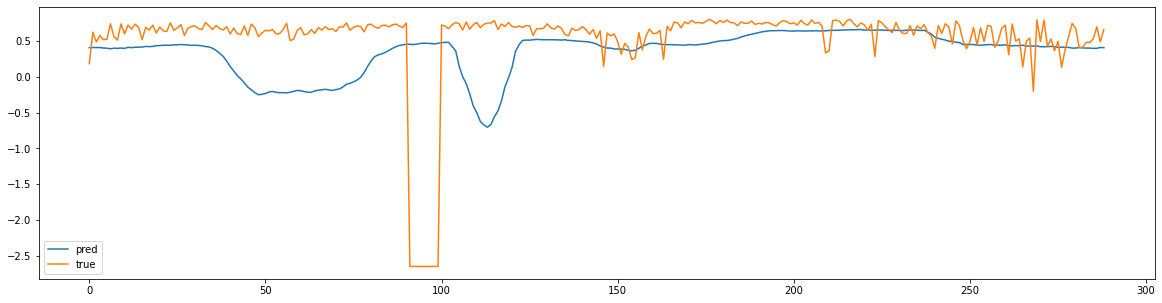

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,5))
sns.lineplot(data=predictions, label="pred")
sns.lineplot(data=targets, label="true")

In [ ]:
import numpy as np
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric_temporal.nn.recurrent import A3TGCN2
import pytorch_lightning as L
from pytorch_lightning.callbacks import EarlyStopping, Timer
from torch.utils.data import DataLoader, TensorDataset, random_split

# Data Preparation
def prepare_data(train_dataset, test_dataset, batch_size, val_split=0.1, shuffle=True):
    # Prepare train data
    train_input = np.array(train_dataset.features)
    train_target = np.array(train_dataset.targets)
    train_x_tensor = torch.from_numpy(train_input).type(torch.FloatTensor)
    train_target_tensor = torch.from_numpy(train_target).type(torch.FloatTensor)

    # Create validation split
    dataset_size = len(train_x_tensor)
    val_size = int(val_split * dataset_size)
    train_size = dataset_size - val_size
    train_dataset, val_dataset = random_split(TensorDataset(train_x_tensor, train_target_tensor),
                                              [train_size, val_size])

    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle, drop_last=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, drop_last=True)

    # Prepare test data
    test_input = np.array(test_dataset.features)
    test_target = np.array(test_dataset.targets)
    test_x_tensor = torch.from_numpy(test_input).type(torch.FloatTensor)
    test_target_tensor = torch.from_numpy(test_target).type(torch.FloatTensor)
    test_dataset = TensorDataset(test_x_tensor, test_target_tensor)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=True)

    return train_loader, val_loader, test_loader

## 6- Parameters optimization

In [ ]:
import pytorch_lightning as L
import torch
import torch.nn.functional as F
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
from torch.utils.data import DataLoader

def train_model(hparams):
    model = TemporalGNN(
        node_features=2,
        periods=12,
        batch_size=hparams['batch_size'],
        lr=hparams['lr'],
        weight_decay=hparams['weight_decay']
    )
    model.set_static_edge_index(static_edge_index.to(DEVICE))

    early_stopping = EarlyStopping(patience=15, monitor="val_loss", mode="min")
    lr_monitor = LearningRateMonitor(logging_interval='step')

    logger = TensorBoardLogger("lightning_logs", name="temporal_gnn")

    trainer = L.Trainer(
        accelerator="gpu" if torch.cuda.is_available() else "cpu",
        devices=1 if torch.cuda.is_available() else None,
        max_epochs=100,
        callbacks=[early_stopping, lr_monitor],
        logger=logger,
        log_every_n_steps=10
    )

    trainer.fit(model, train_loader, val_loader)

    return trainer.callback_metrics["val_loss"].item()

In [ ]:
# Hyperparameter search space
search_space = {
    'batch_size': [16, 32, 64],
    'lr': [1e-3, 5e-4, 1e-4],
    'weight_decay': [1e-5, 1e-4, 1e-3]
}

In [ ]:
# Simple grid search
best_val_loss = float('inf')
best_hparams = {}

for batch_size in search_space['batch_size']:
    for lr in search_space['lr']:
        for weight_decay in search_space['weight_decay']:
            hparams = {
                'batch_size': batch_size,
                'lr': lr,
                'weight_decay': weight_decay
            }
            val_loss = train_model(hparams)
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_hparams = hparams

In [ ]:
print(f"Best hyperparameters: {best_hparams}")
print(f"Best validation loss: {best_val_loss}")

Best hyperparameters: {'batch_size': 16, 'lr': 0.001, 'weight_decay': 1e-05}
Best validation loss: 0.4375171363353729
